In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/tune_results/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/tune_processed/"


sys.path.append("/content/drive/My Drive/collab/TADAT/") 

#configs
N_SEEDS=8
N_VAL_SEEDS = 4
N_VAL_RUNS = 4
N_TASKS = 3
# N_TASKS = 50
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"
PLOT_VAR = "auroc"

# GROUPS = { "GENDER": ["M","F"],
#          "ETHNICITY_BINARY": ["WHITE","NON-WHITE"],
#          "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
# }
GROUPS = { "GENDER": ["M","F"],   
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}

CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'

In [3]:
from collections import defaultdict
from datetime import datetime
# import dill
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings, berter, transformer_lms, transformer_encoders

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

# Modeling 

In [4]:
#torch model
class MyLinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim, loss_fn, optimizer=None, 
                 default_lr=None, init_seed=None, n_epochs=4, 
                 batch_size=None, shuffle_seed=None, silent=False, 
                 shuffle=False, device=None):
        super().__init__()
        if not device: self.device = get_device(silent=True)
        self.batch_size = batch_size
        self.shuffle_seed = shuffle_seed
        self.shuffle = shuffle
        self.silent = silent
        self.loss_fn = loss_fn
        self.n_epochs = n_epochs
        self.model = torch.nn.Linear(in_dim, out_dim)
        if init_seed: 
            torch.manual_seed(init_seed)        
            #initialize random weights
            torch.nn.init.uniform_(self.model.weight, a=-1, b=1)
        if optimizer:
            self.optimizer = optimizer(self.model.parameters())
        else:
            if default_lr:
                self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                                  lr=default_lr)
            else:
                self.optimizer = torch.optim.Adam(self.model.parameters())

    def forward(self, in_dim, out_dim):
        return self.model(in_dim, out_dim)

    def fit(self, X_train, Y_train, X_val, Y_val):      
        X_train = torch.from_numpy(X_train.astype(np.float32))
        Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)
        X_val = torch.from_numpy(X_val.astype(np.float32))
        Y_val = torch.tensor(Y_val, dtype=torch.float32).reshape(-1, 1)

        train_len = X_train.shape[0]        
        rng = RandomState(self.shuffle_seed)        
        if not self.batch_size:        
            self.batch_size = train_len
            n_batches = 1
        else:
            n_batches = int(train_len/self.batch_size)+1            
        #send validation data and model to device
        X_val_ = X_val.to(self.device) 
        Y_val_ = Y_val.to(self.device)
        X_train_ = X_train.to(self.device)
        Y_train_ = Y_train.to(self.device)
        self.model = self.model.to(self.device) 
        idx = torch.tensor(rng.permutation(train_len))
        idx_ = idx.to(self.device) 

        train_losses = []
        val_losses = []
        val_loss_value=float('inf') 
        best_val_loss=float('inf')     
        n_val_drops=0   
        MAX_VAL_DROPS=10
        loss_margin = 1e-3      
        tmp_model_fname = str(uuid.uuid4())+".pt"
        if not self.silent: print("[tmp: {}]".format(tmp_model_fname))
        for it in range(self.n_epochs):    
            t0_epoch = time.time()
            if self.shuffle:                                     
                X_train_ = X_train[idx_].to(self.device)
                Y_train_ = Y_train[idx_].to(self.device)                        
                idx = torch.tensor(rng.permutation(train_len))
                idx_ = idx.to(self.device) 
            for j in range(n_batches):                
                x_train = X_train_[j*self.batch_size:(j+1)*self.batch_size, :]
                y_train = Y_train_[j*self.batch_size:(j+1)*self.batch_size]                
                y_hat_train = self.model(x_train)
                train_loss = self.loss_fn(y_hat_train, y_train)                
                train_loss_value = train_loss.item()
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()                
                train_losses.append(train_loss_value)        
                val_losses.append(val_loss_value)   
            outputs_val = self.model(X_val_)
            val_loss = self.loss_fn(outputs_val, Y_val_)      
            val_loss_value =  val_loss.item()     
            if val_loss_value < best_val_loss:    
                n_val_drops=0            
                best_val_loss = val_loss
                #save best model
                # print("[updating best model]")
                torch.save(self.model.state_dict(), tmp_model_fname)
            elif val_loss_value > best_val_loss - loss_margin:                
                n_val_drops+=1
                # if n_val_drops == MAX_VAL_DROPS:
                #     print("[early stopping: {} epochs]".format(it))
                    # break
            if (it + 1) % 50 == 0 and not self.silent:
                time_elapsed = time.time() - t0_epoch
                print(f'[Epoch {it+1}/{self.n_epochs} | Training loss: {train_loss_value:.4f} | Val loss: {val_loss_value:.4f} | ET: {time_elapsed:.2f}]')
        self.model.load_state_dict(torch.load(tmp_model_fname))
        os.remove(tmp_model_fname)
        # self.model = self.model.cpu()
        return train_losses, val_losses  

    def predict_proba(self, X):        
        X = torch.from_numpy(X.astype(np.float32))
        X_ = X.to(self.device)        
        self.model = self.model.to(self.device) 

        with torch.no_grad():
            y_hat_prob = torch.nn.functional.sigmoid(self.model(X_))
            y_hat_prob =  y_hat_prob.cpu().numpy()
        return y_hat_prob

    def predict(self, X):        
        y_hat_prob = self.predict_proba(X)
        threshold = 0.5 
        y_hat = (y_hat_prob > threshold)
        return y_hat

def get_device(silent=False):
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        if not silent:            
            print('GPU device name:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        if not silent:
            print('No GPU available, using the CPU instead.')        
    return device

In [5]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    if CLASSIFIER == "torch":        
        x = MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.1, batch_size=None, 
                    shuffle_seed=shuffle_seed, silent=False,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, subgroup, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat_prob)       
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,  
            "group":subgroup,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        helpers.save_results(res, res_path, sep="\t")
    return res

def vectorize_train(df_train, df_val, subject_ids):
    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = vectorizer.label2idx(val_Y, label_vocab)
    
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 

    return train_idxs, train_Y, val_idxs, val_Y, label_vocab

def vectorize_test(df_test, subject_ids, label_vocab):    
    subgroup_idxs = defaultdict(dict)             
    #vectorize labels               
    test_Y,_ = vectorizer.label2idx(df_test["Y"], label_vocab)   
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    subgroup_idxs["all"] = [test_idxs, test_Y]
    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            df_subgroup = df_test[df_test[group] == subgroup]
            print("[subgroup: {} | size: {}]".format(subgroup, len(df_subgroup)))
            #vectorize labels               
            test_Y_G,_ = vectorizer.label2idx(df_subgroup["Y"], label_vocab)            
            #get indices into the feature matrix
            idxs = [subject_ids.index(i) for i in list(df_subgroup["SUBJECT_ID"])] 
            if subgroup == "M":
                subgroup = "men"
            elif subgroup == "F":
                subgroup = "women"
            subgroup_idxs[subgroup.lower()] = [idxs, test_Y_G]

    return test_idxs, test_Y, subgroup_idxs

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  transformer_lms.transformer_encode_batches(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  transformer_lms.transformer_encode_batches(data, cls_features=True,
                                                        batchsize=64)        
    elif feature_type == "MULTI-BERT-POOL":
        X =  transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=64,
                                                         tmp_path=TMP_PATH)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats



# Run

In [6]:
def read_dataset(path, dataset_name, df_patients):    
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   


def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = pickle.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        pickle.dump(o, fo)

        
def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))      

def run(data_path, dataset, features_path, feature_type, cache_path, 
                  subsample=False):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    subject_ids, feature_matrix = extract_features(feature_type, features_path)
    train_idx, train_Y, val_idx, val_Y, label_vocab = vectorize_train(df_train, 
                                                                       df_val, 
                                                                       subject_ids)
    test_idxs, test_Y, subgroup_idxs = vectorize_test(df_test, subject_ids, label_vocab) 
    #slice the feature matrix to get the corresponding instances
    train_X = feature_matrix[train_idx, :]    
    val_X = feature_matrix[val_idx, :]
    test_X = feature_matrix[test_idxs,:]
    random.seed(1) #ensure repeateable runs 
    random_seeds = random.sample(range(0, 10000), N_SEEDS)        
    incremental_results = {} 
    test_sets = {}
    ##train/test classifier for each random seed pair
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = {}
            print(" > seed: {}".format(seed))                        
            model = train_classifier(train_X, train_Y,val_X, val_Y,  
                                     input_dimension=train_X.shape[1],
                                     init_seed=init_seed, 
                                     shuffle_seed=shuffle_seed)                                                      
            #test each subgroup (note thtat *all* is also a subgroup)
            for subgroup in subgroup_idxs.keys():                                
                test_idx_G, test_Y_G = subgroup_idxs[subgroup]                 
                test_X_G = feature_matrix[test_idx_G, :]                
                res_g = evaluate_classifier(model, test_X_G, test_Y_G, 
                                            label_vocab, feature_type, seed, subgroup)                
                curr_results[subgroup]= res_g               
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | seed: {}".format(seed))        
        
        incremental_results = merge_results(curr_results, incremental_results, 
                                            list(subgroup_idxs.keys()))
    #build dataframes 
    df_results = results_to_df(incremental_results, subgroup_idxs.keys())
    return df_results

def merge_results(curr_results, results, subgroups):
    #append results    
    for subgroup in subgroups:                
        res = curr_results[subgroup]
        try:
            results[subgroup].append(res)            
        except KeyError:
            results[subgroup] = []
            results[subgroup].append(res)            
    return results

def results_to_df(results, subgroups):
#     df_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    df_results = {}
    df_res = pd.DataFrame(results["all"])            
    for subgroup in subgroups:        
        # if subgroup == "all": continue
        df_res_g = pd.DataFrame(results[subgroup])        
        df_res_delta = df_res_g.sub(df_res.iloc[:,3:])
        # from pdb import set_trace; set_trace()
        df_res_delta["model"] = df_res_g["model"]
        df_res_delta["seed"] = df_res_g["seed"]
        df_res_delta["group"] = df_res_g["group"] 
        df_results[subgroup] = {}
        df_results[subgroup]["results"] = df_res_g
        df_results[subgroup]["delta"] = df_res_delta
        
    return dict(df_results)



# Analyses

In [7]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, clear_results=False, tune_metric=None, plot_metric="auroc"):    

    if clear_results:
        clear_cache(cache_path, model=feature_type, dataset=dataset, ctype="res*")
    if tune_metric:
        df_results = tune_run(data_path, dataset, features_path, feature_type, cache_path, tune_metric)  
        fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:
        df_results = run(data_path, dataset, features_path, feature_type, cache_path)         
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()
        
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)  
#     write_cache(results_path+fname, df_results)
    write_cache(results_path+fname, df_results)
    if plot_metric:           
        plot_scatters(df_results, plot_metric, dataset)
        plot_deltas(df_results, plot_metric, dataset)
    return df_results               

#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             reset=False, tune_metric=None, plot_metric=None, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, clear_results=False, tune_metric=tune_metric, 
                         plot_metric=plot_metric)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False

def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass
        
def plot_scatters(results, metric, title):
    n_rows=2
    n_cols = 3    
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(12,5), sharex=True, sharey=True)
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))   
    try:
        del results["all"]
    except KeyError:
        pass
    for subgroup, col, coord in zip(results.keys(), cmap, coords ):
        df = results[subgroup]["results"]
        df_delta = results[subgroup]["delta"]
        
        df_all = df.merge(df_delta, on=["model","seed","group"],
                                      suffixes=[None, "_delta"])
        # print(len(df_all))
        jitter_x = np.random.randn(len(df_all)) * .005
        jitter_y = np.random.randn(len(df_all)) * .005
        #get absolute values for the deltas    
        df_all[metric+"_delta"] = df_all[metric+"_delta"].abs() + jitter_y
        df_all[metric] += jitter_x

        df_all.plot.scatter(x=metric,y=metric+"_delta",
                            c=col, ax=ax[coord[0]][coord[1]])
        ax[coord[0]][coord[1]].set_title(subgroup)
    fig.suptitle(title, y=1.02)
    plt.tight_layout()    
    
def plot_deltas(results, metric, title):
    try:
        del results["all"]
    except KeyError:
        pass
    df_delta = pd.concat([results[g]["delta"] for g in list(results.keys())])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], 
                                  value_vars=[metric], 
                                  var_name="metric", value_name="delta")
    jitter_x = np.random.randn(len(df_delta_long)) * .005
    df_delta_long["delta"]+=jitter_x
    g = sns.catplot(x="group", y="delta", data=df_delta_long, 
                    col="metric",sharey=True,legend=False)    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
        ax.set_ylim([-lim,lim])
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  

def plot_analyses(results_path, dataset, feature_type, plot_metric, tune_metric=None):
    if tune_metric:
        fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:        
        fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

#     df_results = read_cache(results_path+fname)   
    df_results = read_cache(results_path+fname)
    if df_results:
        plot_scatters(df_results, plot_metric, dataset)
        plot_deltas(df_results, plot_metric, dataset)


def plot_tasks(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            plot_analyses(results_path, dataset, feature_type, plot_metric, tune_metric)

def get_gaps(results, dataset_name, metric):    
    all_dfs = [results[g]["results"][["seed", metric]] for g in results.keys()]
    all_dfs = pd.concat(all_dfs)
    diff_df = (all_dfs.groupby("seed").max() - all_dfs.groupby("seed").min()).reset_index()
    diff_df["dataset"] = [dataset_name]*len(diff_df)
    return diff_df

def plot_gaps(tasks_fname, feature_type, results_path, 
               mini_tasks=True, plot_metric=None, tune_metric=None):
    dfs = []
    with open(tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            task_abv, task_name = l.strip("\n").split(",")
            dataset = "mini-"+task_abv if mini_tasks else task_abv
            if tune_metric:
                fname = "{}_{}_all_tuned_res.pkl".format(dataset, feature_type).lower()
            else:        
                fname = "{}_{}_all_res.pkl".format(dataset, feature_type).lower()

            df_results = read_cache(results_path+fname)    
            if df_results:
                df_gaps = get_gaps(df_results, task_abv, plot_metric)
                dfs.append(df_gaps)
    dfs = pd.concat(dfs)
    g = sns.catplot(x="dataset", y=plot_metric, data=dfs, sharey=True,legend=True, legend_out=True, height=5, aspect=1.5)        
    g.set_ylabels(plot_metric + " gap")
    lim = max(dfs[plot_metric].abs()) + 0.05
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    # plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  

# Main

[train/test set size: 1000/1000]
[sklearn classifier]
[reading cached features]
[subgroup: M | size: 545]
[subgroup: F | size: 455]
[subgroup: WHITE | size: 686]
[subgroup: BLACK | size: 104]
[subgroup: ASIAN | size: 11]
[subgroup: HISPANIC | size: 29]
loaded cached results | seed: 2201x2201
loaded cached results | seed: 2201x9325
loaded cached results | seed: 2201x1033
loaded cached results | seed: 2201x4179
loaded cached results | seed: 2201x1931
loaded cached results | seed: 2201x8117
loaded cached results | seed: 2201x7364
loaded cached results | seed: 2201x7737
loaded cached results | seed: 9325x2201
loaded cached results | seed: 9325x9325
loaded cached results | seed: 9325x1033
loaded cached results | seed: 9325x4179
loaded cached results | seed: 9325x1931
loaded cached results | seed: 9325x8117
loaded cached results | seed: 9325x7364
loaded cached results | seed: 9325x7737
loaded cached results | seed: 1033x2201
loaded cached results | seed: 1033x9325
loaded cached results | see

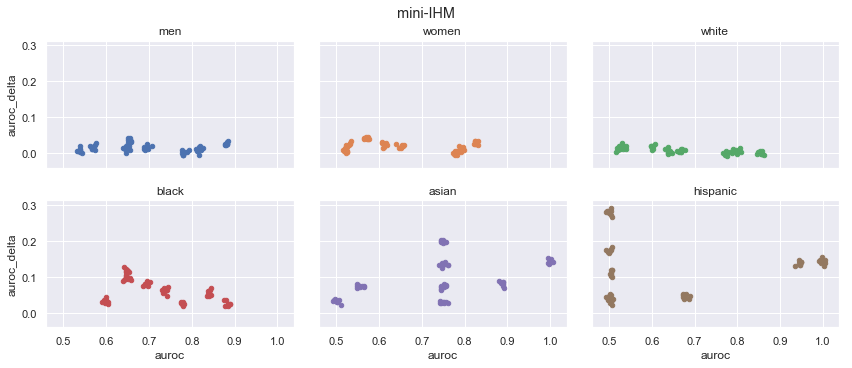

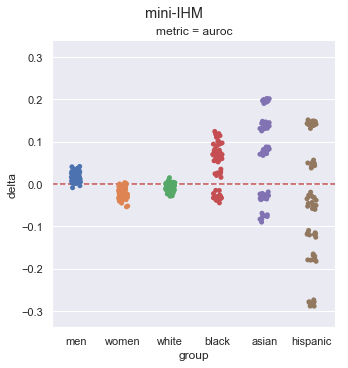

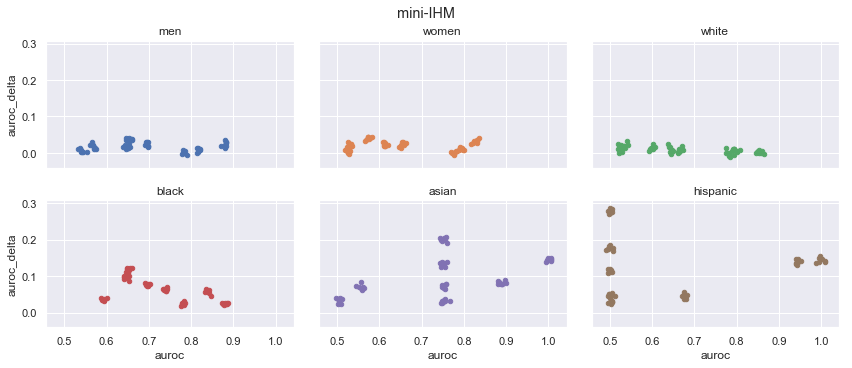

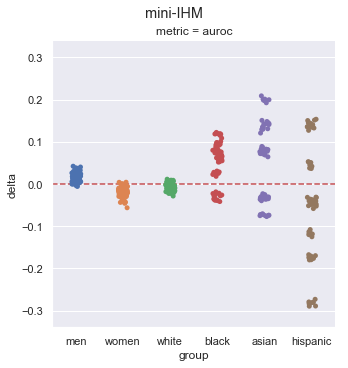

In [14]:
dataset="IHM"
dataset="mini-"+dataset
CLASSIFIER="sklearn"
PLOT_METRIC="auroc"
Z = run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, BASE_PATH+"/DATA/processed_malaike", 
             clear_results=False, tune_metric=None, plot_metric=PLOT_VAR)
plot_analyses(OUTPUT_PATH, dataset, MODEL, plot_metric=PLOT_METRIC, tune_metric=None)


In [9]:
plot_gaps(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=False, plot_metric=PLOT_VAR, tune_metric=None)

ModuleNotFoundError: No module named 'MIMIC_Outcomes'

In [ ]:
CLASSIFIER="sklearn"
# run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

In [ ]:
#Run tasks
# run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, 
#           tune_metric=None, plot_metric=None, mini_tasks=True)
plot_tasks(INPUT_PATH+"tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=True, plot_metric=PLOT_METRIC, tune_metric=None)

In [ ]:
#Run tasks with tuning
TUNE_METRIC = "auprc"
run_tasks(INPUT_PATH+"tasks.txt", FEATURES_PATH, MODEL, TUNE_TMP_PATH, TUNE_OUTPUT_PATH, mini_tasks=True, reset=True, tune_metric=TUNE_METRIC)
# plot_tasks(INPUT_PATH, "tasks.txt", MODEL, TUNE_OUTPUT_PATH, mini_tasks=True, tune_metric=TUNE_METRIC)